# Eda - Matheus Miranda Brandão

## Importando as bibliotecas necessárias

In [61]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("crest", as_cmap=True)
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from tqdm import tqdm
tqdm.pandas(desc="my bar!")

## Tables

Carregando o banco de dados, já tratado anteriormente

In [62]:
df = pd.read_pickle('../../datasets/processed/movies.pkl')
df.head()

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income_$,country_of_origin
0,Avatar: The Way of Water,8.0,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,$350000000,681081686,United States
1,Guillermo del Toro's Pinocchio,7.8,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,$35000000,71614,"United States, Mexico, France"
2,Bullet Train,7.3,2022,August,R,127,David Leitch,"Brad Pitt, Joey King, Aaron Taylor Johnson, Br...","Action, Comedy, Thriller",Japan,$85900000,239268602,"Japan, United States"
3,The Banshees of Inisherin,8.0,2022,November,R,114,Martin McDonagh,"Colin Farrell, Brendan Gleeson, Kerry Condon, ...","Comedy, Drama",Ireland,Unknown,19720823,"Ireland, United Kingdom, United States"
4,M3gan,6.7,2022,January,PG-13,102,Gerard Johnstone,"Jenna Davis, Amie Donald, Allison Williams, Vi...","Horror, Sci-Fi, Thriller",New Zealand,Unknown,90776006,United States


Observando como os dados numericos se comportam.

Budget não incluso, pois tem diferentes tipos de moedas.

In [63]:
df.describe()

,rating,year,runtime,income_$
count,2000.000000,2000.000000,2000.000000,2.000000e+03
mean,6.667650,2012.500000,113.214500,1.807404e+08
std,0.912576,5.767723,19.598075,2.645420e+08
min,1.900000,2003.000000,50.000000,3.050000e+02
25%,6.175000,2007.750000,99.000000,2.931354e+07
50%,6.700000,2012.500000,110.000000,9.077601e+07
75%,7.300000,2017.250000,124.000000,2.081357e+08
max,9.600000,2022.000000,242.000000,2.922918e+09


Observando os dados categóricos.

In [64]:
df.describe(exclude=['float64', 'uint16', 'uint32', 'uint8'])

,title,month,certificate,directors,stars,genre,filming_location,budget,country_of_origin
count,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,1989,12,11,1082,1990,244,97,305,406
top,The Hunt,November,R,Ridley Scott,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw...","Action, Adventure, Sci-Fi",USA,Unknown,United States
freq,2,262,901,13,2,92,906,306,942


In [65]:
def drop_space_left_right(x):
    if x[0] in ' ':
        return x[1:]
    elif  x[-1] in ' ':
        return x[:-1]
    else:
        return x

list_of_stars = pd.Series(np.sum((df.stars) + ', ').split(','))
list_of_stars = pd.DataFrame(list(set(list_of_stars.progress_apply(drop_space_left_right))), columns=['star'])
del drop_space_left_right
list_of_stars.drop(index=1, inplace=True)
list_of_stars.reset_index(inplace=True, drop=True)

my bar!: 100%|██████████| 7998/7998 [00:00<00:00, 890807.89it/s]


In [66]:
list_of_stars['frequency'] = [df.stars.str.contains(star).sum() for star in tqdm(list_of_stars.star.values)]

100%|██████████| 3502/3502 [00:02<00:00, 1347.31it/s]


In [67]:
list_of_stars.sort_values('frequency', ascending=False).head(10)

,star,frequency
3074,Dwayne Johnson,25
712,Mark Wahlberg,24
1762,Ryan Reynolds,23
351,Scarlett Johansson,22
2393,Amy Adams,22
2403,Matt Damon,22
1330,Brad Pitt,22
1619,Liam Neeson,21
2821,Tom Hanks,21
720,Cate Blanchett,21


In [68]:
list_of_stars.sort_values('frequency', ascending=True).head(10)

,star,frequency
3501,Anita Briem,1
1592,John Henshaw,1
1593,Cailee Spaeny,1
1594,Kevin Dillon,1
1595,Stephen McKinley Henderson,1
2803,Tom Hopper,1
1597,Christian Cooke,1
2804,Lim Soo jung,1
2802,Kayvan Novak,1
1600,Marianne Jean Baptiste,1


Drop na coluna 'stars'

In [9]:
df.drop(columns='stars', inplace=True)

Ao agrupar por ano vemos a média, mediana e somatório.

In [10]:
df.groupby('year').agg({
    'rating': ['mean', 'median', 'sum'], 
    'runtime': ['mean', 'median', 'sum'],
    'income_$': ['mean', 'median', 'sum']
})

rating               runtime                    income_$               \
       mean median    sum    mean median    sum          mean       median   
year                                                                         
2003  6.579   6.70  657.9  110.79  108.0  11079  1.483425e+08   90517771.0   
2004  6.746   6.80  674.6  111.03  106.0  11103  1.565439e+08  102824419.5   
2005  6.565   6.70  656.5  111.15  109.0  11115  1.414480e+08   89008395.5   
2006  6.713   6.75  671.3  112.87  108.0  11287  1.444764e+08   85695102.5   
2007  6.756   6.95  675.6  112.12  109.5  11212  1.620166e+08   90776006.0   
2008  6.596   6.70  659.6  107.73  106.0  10773  1.783801e+08  112237665.5   
2009  6.679   6.75  667.9  111.85  107.0  11185  1.872593e+08   90809326.0   
2010  6.691   6.60  669.1  108.69  107.0  10869  1.875894e+08   93954579.0   
2011  6.754   6.80  675.4  110.60  107.5  11060  1.977062e+08  130071931.5   
2012  6.675   6.75  667.5  112.58  109.0  11258  2.266304e+08  121553838.5   
2013  6.734   6.75  673.4  113.67  112.0  11367  2.132888e+08   98721049.5   
2014  6.692   6.60  669.2  113.05  109.0  11305  2.213606e+08  124898098.5   
2015  6.688   6.75  668.8  116.02  117.0  11602  2.273229e+08   91373416.5   
2016  6.762   6.85  676.2  114.25  114.5  11425  2.209106e+08  119310390.5   
2017  6.714   6.70  671.4  115.10  115.0  11510  2.276579e+08   90776006.0   
2018  6.677   6.75  667.7  117.24  118.0  11724  2.363394e+08   90776006.0   
2019  6.691   6.75  669.1  117.37  117.0  11737  2.339085e+08   90776006.0   
2020  6.326   6.50  632.6  107.80  105.5  10780  6.910270e+07   48580004.0   
2021  6.612   6.60  661.2  118.09  114.5  11809  1.161049e+08   40772055.0   
2022  6.703   6.70  670.3  122.29  118.5  12229  1.184192e+08   90776006.0   

                   
              sum  
year               
2003  14834247101  
2004  15654392307  
2005  14144800243  
2006  14447635031  
2007  16201657520  
2008  17838006391  
2009  18725925460  
2010  18758936169  
2011  19770619533  
2012  22663036621  
2013  21328875848  
2014  22136060623  
2015  22732291010  
2016  22091058256  
2017  22765791070  
2018  23633941239  
2019  23390851105  
2020   6910269535  
2021  11610487877  
2022  11841920151

Observando a moda dos dados categóricos por ano

In [11]:
df.groupby('year')[
    [
        'month', 'certificate', 
        'directors', 'filming_location', 
        'budget', 'country_of_origin'
    ]
].agg(lambda x: x.mode()[0])

,month,certificate,directors,filming_location,budget,country_of_origin
year,,,,,,
2003,November,R,"Lana Wachowski, Lilly Wachowski",USA,$60000000,United States
2004,July,R,Garry Marshall,USA,$30000000,United States
2005,December,PG-13,Catherine Hardwicke,USA,$50000000,United States
2006,November,R,Shawn Levy,USA,Unknown,United States
2007,November,R,Richard LaGravenese,USA,Unknown,United States
2008,December,PG-13,Clint Eastwood,USA,$20000000,United States
2009,December,R,Christian Alvart,USA,$30000000,United States
2010,June,R,Adam Green,USA,Unknown,United States
2011,August,R,Steven Spielberg,USA,$40000000,United States


Proporção de classificação indicativa nos filmes.

In [12]:
pd.DataFrame(zip(
    df.certificate.value_counts(), 
    df.certificate.value_counts(normalize=True)
    ), index=df.certificate.value_counts().index, columns=['count', 'percentage'])

,count,percentage
R,901,0.4505
PG-13,714,0.3570
PG,225,0.1125
Unrated,67,0.0335
TV-MA,40,0.0200
G,22,0.0110
TV-14,12,0.0060
TV-PG,9,0.0045
NC-17,6,0.0030
TV-G,3,0.0015


Proporção de locação nos filmes

In [13]:
pd.DataFrame(zip(
    df.filming_location.value_counts(), 
    df.filming_location.value_counts(normalize=True)
    ), index=df.filming_location.value_counts().index, columns=['count', 'percentage'])

,count,percentage
USA,906,0.4530
Canada,209,0.1045
UK,177,0.0885
Unknown,76,0.0380
Australia,44,0.0220
...,...,...
Guam,1,0.0005
Gabon,1,0.0005
French Polynesia,1,0.0005
Rwanda,1,0.0005


Como o país de origem é um string, procuramos os resultados que tem United States incluso.

In [14]:
df[df.country_of_origin.str.contains('United States')].shape

(1784, 12)

In [15]:
pd.DataFrame(zip(
    df.country_of_origin.value_counts(), 
    df.country_of_origin.value_counts(normalize=True)
    ), index=df.country_of_origin.value_counts().index, columns=['count', 'percentage'])

,count,percentage
United States,942,0.4710
"United Kingdom, United States",95,0.0475
"United States, United Kingdom",74,0.0370
"United States, Canada",73,0.0365
United Kingdom,34,0.0170
...,...,...
"United States, France, Hong Kong",1,0.0005
"France, Belgium, United States",1,0.0005
"United States, China, Spain, Japan, Germany",1,0.0005
"Canada, United States, United Kingdom",1,0.0005


Proporção da janela de lançamento de filmes

In [16]:
pd.DataFrame(zip(
    df.month.value_counts(), 
    df.month.value_counts(normalize=True)
    ), index=df.month.value_counts().index, columns=['count', 'percentage'])

,count,percentage
November,262,0.1310
December,248,0.1240
October,187,0.0935
June,166,0.0830
July,152,0.0760
September,151,0.0755
March,150,0.0750
August,149,0.0745
January,149,0.0745
May,144,0.0720


Restringimos nosso dataset onde o budget é dado em $. Para converte-lo em numérico

In [17]:
def array_to_int(array):
    return array[0]

series = df[df.budget.str.contains('[$]', regex=True)].budget.str.findall(r'\d+').apply(array_to_int).astype('int64')
df_budget = df.iloc[series.index, :].copy()
df_budget.budget = series
del series, array_to_int

Calculado o lucro bruto e relativo

In [18]:
df_budget['profit'] = df_budget['income_$'] - df_budget.budget
df_budget['proportional_profit'] = np.round(df_budget['income_$']/df_budget.budget*100, 2)

Observando os valores max e min

In [19]:
df_budget.query('profit == @df_budget.profit.min() | profit == @df_budget.profit.max()')

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
123,Zack Snyder's Justice League,8.0,2021,March,R,242,Zack Snyder,"Action, Adventure, Fantasy",Iceland,300000000,90776006,United States,-209223994,30.26
1300,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Action, Adventure, Fantasy",USA,237000000,2922917914,United States,2685917914,1233.30


In [20]:
df_budget.query('proportional_profit == @df_budget.proportional_profit.min() | proportional_profit == @df_budget.proportional_profit.max()')

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
11,Babylon,7.7,2022,December,R,188,Damien Chazelle,"Comedy, Drama, History",USA,78000000,1470,United States,-77998530,0.0
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Romance, Drama, Family",Unknown,10,90776006,United States,90775996,907760060.0


Ordenando em relação ao lucro bruto e dps relativo.

In [21]:
df_budget.sort_values('profit', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
1300,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Action, Adventure, Fantasy",USA,237000000,2922917914,United States,2685917914,1233.30
305,Avengers: Endgame,8.4,2019,April,PG-13,181,"Anthony Russo, Joe Russo","Action, Adventure, Drama",UK,356000000,2797501328,United States,2441501328,785.81
714,Star Wars: Episode VII - The Force Awakens,7.8,2015,December,PG-13,138,J J Abrams,"Action, Adventure, Sci-Fi",Ireland,245000000,2069521700,United States,1824521700,844.70
405,Avengers: Infinity War,8.4,2018,April,PG-13,149,"Anthony Russo, Joe Russo","Action, Adventure, Sci-Fi",UK,321000000,2048359754,United States,1727359754,638.12
103,Spider-Man: No Way Home,8.3,2021,December,PG-13,148,Jon Watts,"Action, Adventure, Fantasy",Iceland,200000000,1917430023,United States,1717430023,958.72
723,Jurassic World,6.9,2015,June,PG-13,124,Colin Trevorrow,"Action, Adventure, Sci-Fi",USA,150000000,1671537444,United States,1521537444,1114.36
344,The Lion King,6.8,2019,July,PG,118,Jon Favreau,"Animation, Adventure, Drama",South Africa,260000000,1663250487,"United States, United Kingdom",1403250487,639.71
753,Furious 7,7.1,2015,April,PG-13,137,James Wan,"Action, Crime, Thriller",United Arab Emirates,190000000,1515341399,"United States, China, Japan, Canada, United Ar...",1325341399,797.55
27,Top Gun: Maverick,8.4,2022,May,PG-13,130,Joseph Kosinski,"Action, Drama",USA,170000000,1488732821,United States,1318732821,875.73
335,Frozen II,6.8,2019,November,PG,103,"Chris Buck, Jennifer Lee","Animation, Adventure, Comedy",USA,150000000,1450026933,United States,1300026933,966.68


In [22]:
df_budget.sort_values('proportional_profit', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Romance, Drama, Family",Unknown,10,90776006,United States,90775996,9.077601e+08
1557,Paranormal Activity,6.3,2007,October,R,86,Oren Peli,"Horror, Mystery",USA,15000,193355800,United States,193340800,1.289039e+06
477,The VelociPastor,5.0,2018,August,Unrated,75,Brendan Steere,"Action, Adventure, Comedy",USA,11000,90776006,"United States, China",90765006,8.252364e+05
94,Skinamarink,5.4,2022,January,R,100,Kyle Edward Ball,Horror,Canada,15000,90776006,Canada,90761006,6.051734e+05
1549,The Man from Earth,7.9,2007,November,Unrated,87,Richard Schenkman,"Drama, Fantasy, Mystery",USA,200000,90776006,United States,90576006,4.538800e+04
848,Mantus,2.1,2014,November,R,110,Enzo Zelocchi,"Comedy, Drama, Thriller",USA,250000,90776006,United States,90526006,3.631040e+04
791,Circle,6.0,2015,October,Unrated,87,"Aaron Hann, Mario Miscione","Drama, Horror, Mystery",Unknown,250000,90776006,United States,90526006,3.631040e+04
1193,"67th Street, New York, NY",9.0,2011,January,R,105,Enzo Zelocchi,"Crime, Thriller",Unknown,300000,90776006,United States,90476006,3.025867e+04
771,Angels Apocalypse,8.2,2015,December,R,85,"Sean Cain, Enzo Zelocchi","Action, Fantasy, Sci-Fi",Unknown,500000,90776006,United States,90276006,1.815520e+04
1583,Once,7.8,2007,June,R,86,John Carney,"Drama, Music, Romance",Ireland,150000,20936722,"Ireland, United States",20786722,1.395781e+04


In [23]:
df_budget.sort_values('rating', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Romance, Drama, Family",Unknown,10,90776006,United States,90775996,9.077601e+08
1401,The Dark Knight,9.0,2008,July,PG-13,152,Christopher Nolan,"Action, Crime, Drama",USA,185000000,1006234167,"United States, United Kingdom",821234167,5.439100e+02
1193,"67th Street, New York, NY",9.0,2011,January,R,105,Enzo Zelocchi,"Crime, Thriller",Unknown,300000,90776006,United States,90476006,3.025867e+04
1903,The Lord of the Rings: The Return of the King,9.0,2003,December,PG-13,201,Peter Jackson,"Action, Adventure, Drama",New Zealand,94000000,1146457748,"New Zealand, United States",1052457748,1.219640e+03
1200,Inception,8.8,2010,July,PG-13,148,Christopher Nolan,"Action, Adventure, Sci-Fi",Canada,160000000,836848102,"United States, United Kingdom",676848102,5.230300e+02
800,Interstellar,8.6,2014,November,PG-13,169,Christopher Nolan,"Adventure, Drama, Sci-Fi",Iceland,165000000,773867216,"United States, United Kingdom, Canada",608867216,4.690100e+02
803,Whiplash,8.5,2014,October,R,106,Damien Chazelle,"Drama, Music",USA,3300000,49396747,United States,46096747,1.496870e+03
308,Parasite,8.5,2019,November,R,132,Bong Joon Ho,"Drama, Thriller",South Korea,11400000,262676096,South Korea,251276096,2.304180e+03
1604,The Departed,8.5,2006,October,R,151,Martin Scorsese,"Crime, Drama, Thriller",USA,90000000,291480452,"United States, Hong Kong",201480452,3.238700e+02
45,Kantara,8.5,2022,September,R,148,Rishab Shetty,"Action, Adventure, Drama",Unknown,2000000,2406221,India,406221,1.203100e+02


In [24]:
df_budget.sort_values('rating', ascending=True).head(10)

,title,rating,year,month,certificate,runtime,directors,genre,filming_location,budget,income_$,country_of_origin,profit,proportional_profit
1484,Disaster Movie,1.9,2008,August,PG-13,87,"Jason Friedberg, Aaron Seltzer","Comedy, Sci-Fi",USA,20000000,34816824,United States,14816824,174.08
848,Mantus,2.1,2014,November,R,110,Enzo Zelocchi,"Comedy, Drama, Thriller",USA,250000,90776006,United States,90526006,36310.40
1780,Son of the Mask,2.2,2005,February,PG,94,Lawrence Guterman,"Comedy, Family, Fantasy",Australia,84000000,59981548,"United States, Germany",-24018452,71.41
1524,Epic Movie,2.4,2007,January,PG-13,86,"Jason Friedberg, Aaron Seltzer","Adventure, Comedy, Fantasy",USA,20000000,87238158,United States,67238158,436.19
1369,Dragonball Evolution,2.6,2009,April,PG,85,James Wong,"Action, Adventure, Fantasy",Mexico,30000000,55720772,"United Kingdom, Mexico, Hong Kong, United States",25720772,185.74
1491,Meet the Spartans,2.8,2008,January,PG-13,87,"Jason Friedberg, Aaron Seltzer","Comedy, Fantasy",USA,30000000,85897593,United States,55897593,286.33
331,Cats,2.8,2019,December,PG,110,Tom Hooper,"Comedy, Drama, Family",UK,95000000,75558925,"United Kingdom, United States, Canada, Austral...",-19441075,79.54
1891,Catwoman,3.4,2004,July,PG-13,104,Pitof,"Action, Crime, Fantasy",USA,100000000,82102379,United States,-17897621,82.10
348,Black Christmas,3.5,2019,December,PG-13,92,Sophia Takal,"Horror, Mystery, Thriller",New Zealand,5000000,18529730,"United States, New Zealand, Canada",13529730,370.59
1924,The Room,3.6,2003,June,R,99,Tommy Wiseau,Drama,USA,6000000,4988181,United States,-1011819,83.14


## Plots (Opcional)

### Criando algumas funções para facilitar na plotagem

In [25]:
def create_bar(df_: pd, ax_: plt.axes, x_: str, y_: str, agg_: str, title_:str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].agg(agg_)
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    
    for value in ax_.containers:
        ax_.bar_label(value)
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [26]:
def create_box(df: pd, ax_: plt.axes, x_: str, y_: str, title_:str, rot=45):
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [27]:
def create_pie(df_: pd, ax_: plt.axes, x_: str, y_: str, title_: str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].count()
        
    ax_.pie(data=df, x=y_, labels=x_, autopct = "%1.2f%%", startangle = rot, colors = sns.color_palette('crest'))
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [28]:
def create_scatter(df: pd, ax_: plt.axes, x_: str, y_: str, title_: str):
    sns.scatterplot(data=df, x=x_, y=y_, alpha = 0.75, ax=ax_)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

### Plotando ...

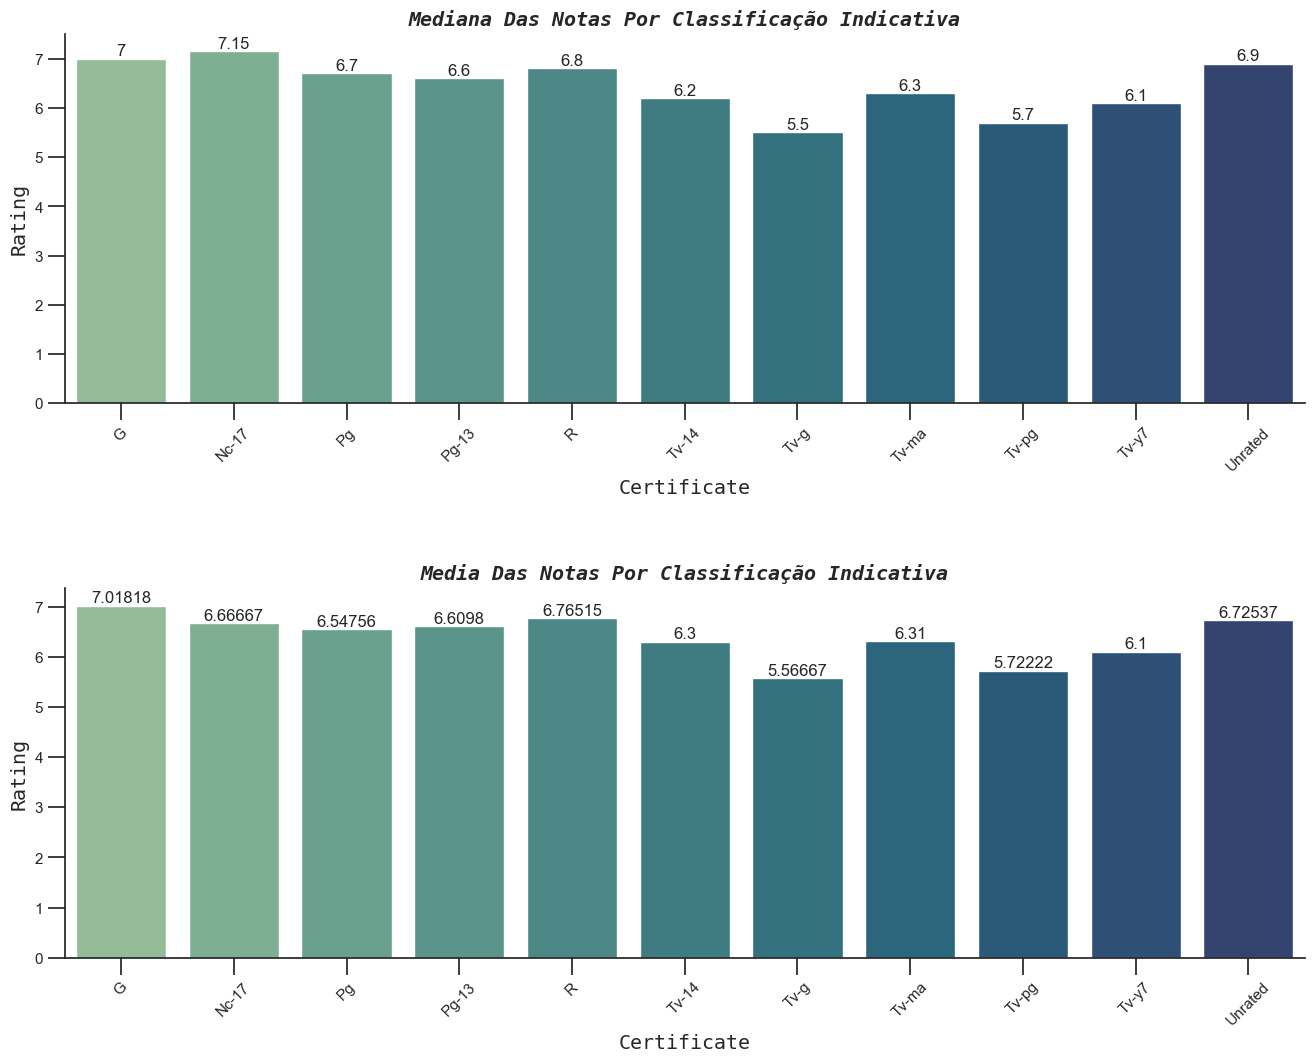

In [29]:
fig, (ax1, ax2) = plt.subplots((2), figsize=(16, 12))
create_bar(df, ax1, 'certificate', 'rating', 'median', 'Mediana das notas por classificação indicativa')
create_bar(df, ax2, 'certificate', 'rating', 'mean', 'Media das notas por classificação indicativa')
plt.subplots_adjust(hspace=.5)
plt.show()

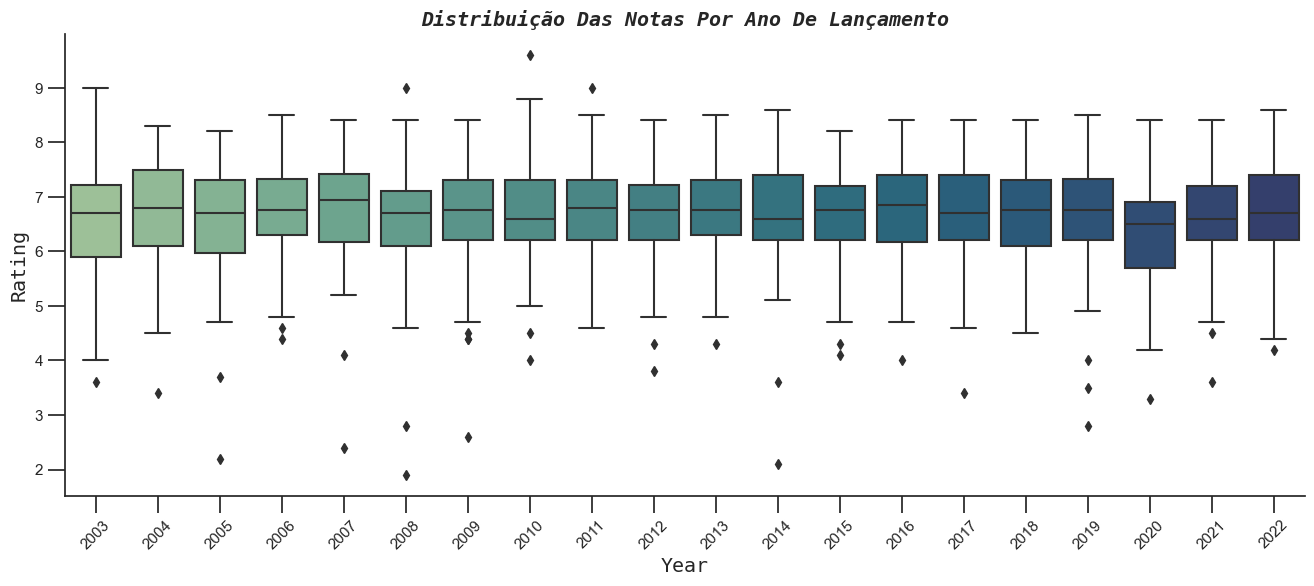

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'year', 'rating', 'Distribuição das notas por ano de lançamento')
plt.show()

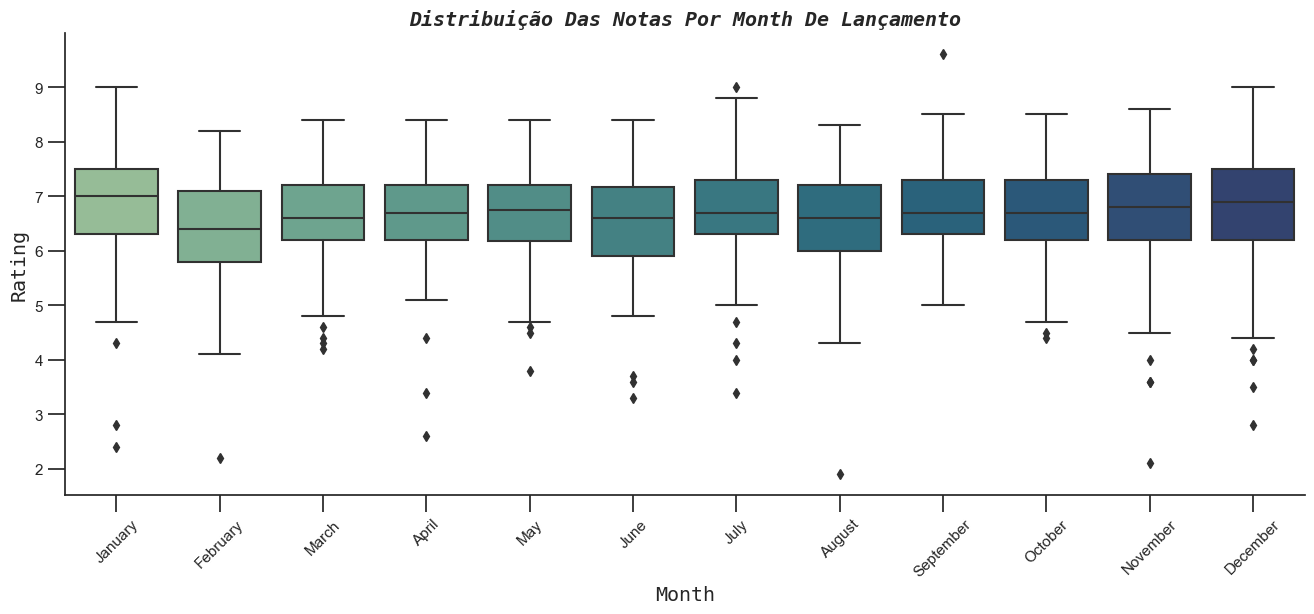

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'month', 'rating', 'Distribuição das notas por month de lançamento')
plt.show()

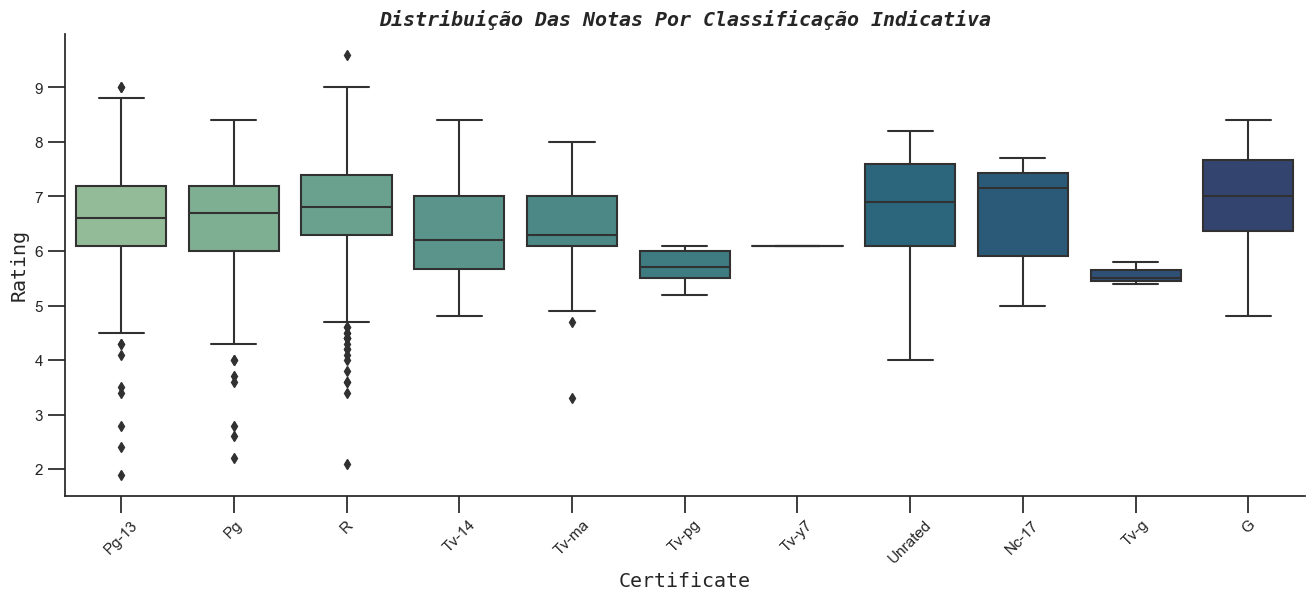

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'certificate', 'rating', 'Distribuição das notas por classificação indicativa')
plt.show()

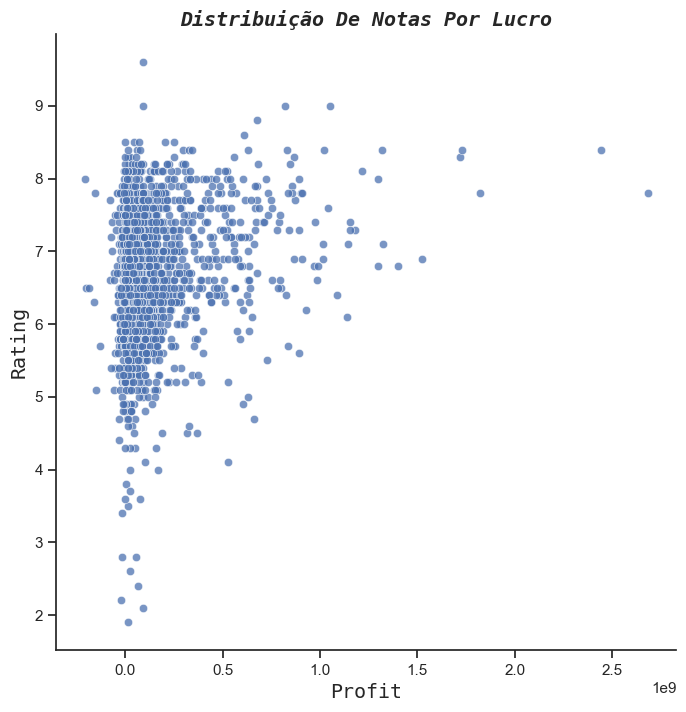

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

create_scatter(df_budget, ax, 'profit', 'rating', 'Distribuição de notas por lucro')

plt.show()

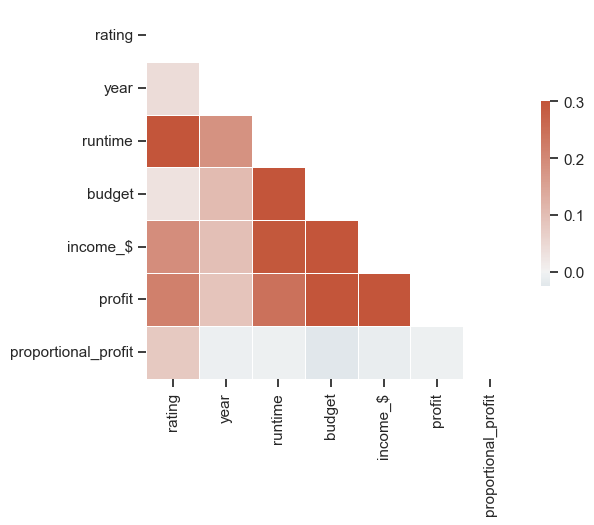

In [34]:
corr = df_budget.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()